### Import modules, define functions, define general input files and variables

In [12]:
import sys
sys.path.append('../')
import deeprank_plots as dp
import os
import h5py
import numpy as np
from numpy.polynomial.polynomial import polyfit
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

import sys
sys.path.append('/home/dmarz/3D-Vac/src/5_train_models')
from DeepRank import classMetrics
from sklearn.metrics import average_precision_score as auprc

import pickle

def get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLA_all.pkl'):
    with open(pklname, 'rb') as inpkl:
        name = pickle.load(inpkl)
        seq = pickle.load(inpkl)
        score = pickle.load(inpkl)
        dist = pickle.load(inpkl)

    matrix = {}
    for i, x in enumerate(name):
        matrix[x] = { y:dist[i+j]  for j, y in enumerate(name[i+1:])}
    
    return matrix

def get_avg_distance(allele, matrix, test_alleles):
    distances = []
    other_alleles = [name for name in matrix.keys() if (name not in test_alleles) and (name != allele)]
    for name in other_alleles:
        if name not in training_allele_freq.keys():
            #print(f'WARNING: allele {allele} not in training alleles frequency')
            if name in test_alleles:
                print(f'Health check: {allele} in test alleles')
                continue
            else:
                print(f'WARNING: allele {name} not in training alleles. Skipping.')
                continue
        
        try:
            distances.append(matrix[allele][name] * training_allele_freq[name]) 
        except KeyError:
            try:
                distances.append(matrix[name][allele] * training_allele_freq[name])
            except KeyError:
                raise KeyError('The provided allele does not seem to belong to this matrix')

    avg_distance = sum(distances)/len(distances)
    return avg_distance

matrix = {}
matrix['A'] = get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLAA.pkl')
matrix['B'] = get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLAB.pkl')
matrix['C'] = get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLAC.pkl')
matrix['ALL'] = get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLA_all.pkl')


clust_dfi = pd.read_csv('/projects/0/einf2380/data/external/processed/I/experiments/BA_pMHCI_human_quantitative_only_eq_pseudoseq_clustered_test.csv')
clust_dfi['label'] = np.where(clust_dfi['measurement_value'] < 500, 1.0, 0.0)

tdf=pd.read_csv(
    '/projects/0/einf2380/data/external/processed/I/experiments/BA_pMHCI_human_quantitative_only_eq_pseudoseq_clustered_train_validation.csv')
training_allele_freq = {}
for allele in list(set(tdf['allele'])):
    training_allele_freq[allele] = (tdf['allele'] == allele).sum()/len(tdf)

test_alleles = list(set(clust_dfi['allele']))

correlations = {}

label_per_model = {'CNN': ('OUTPUT_1', 'TARGET'),
                    'GNN': ('output', 'label'),
                'EGNN': ('OUTPUT_1', 'TARGET'),
                'SSL_woT': ('OUTPUT_1', 'TARGET'),
                'SSL_T': ('OUTPUT_1', 'TARGET'),
                'MLP': ('OUTPUT_1', 'label'),
                'MHCflurry': ('OUTPUT_1', 'label'),
                'MHCflurry_confirm': ('OUTPUT_1', 'label'),
                }

### Get the models output for every model and plot AUC vs evolutionary distance from the training set per allele

Allele HLA-A*24:01 not in Matrix ALL
TITLE CNN, AUC 0.6969536505877688
Allele HLA-A*24:01 not in Matrix ALL
TITLE GNN, AUC 0.7087085808696671
Allele HLA-A*24:01 not in Matrix ALL
TITLE EGNN, AUC 0.7268719479732882
Allele HLA-A*24:01 not in Matrix ALL
TITLE MHCflurry, AUC 0.65456587865395
Allele HLA-A*24:01 not in Matrix ALL
TITLE MLP, AUC 0.6192429568079454
Allele HLA-A*24:01 not in Matrix ALL
TITLE SSL_woT, AUC 0.6409994258429146
Allele HLA-A*24:01 not in Matrix ALL
TITLE SSL_T, AUC 0.6683604900045097


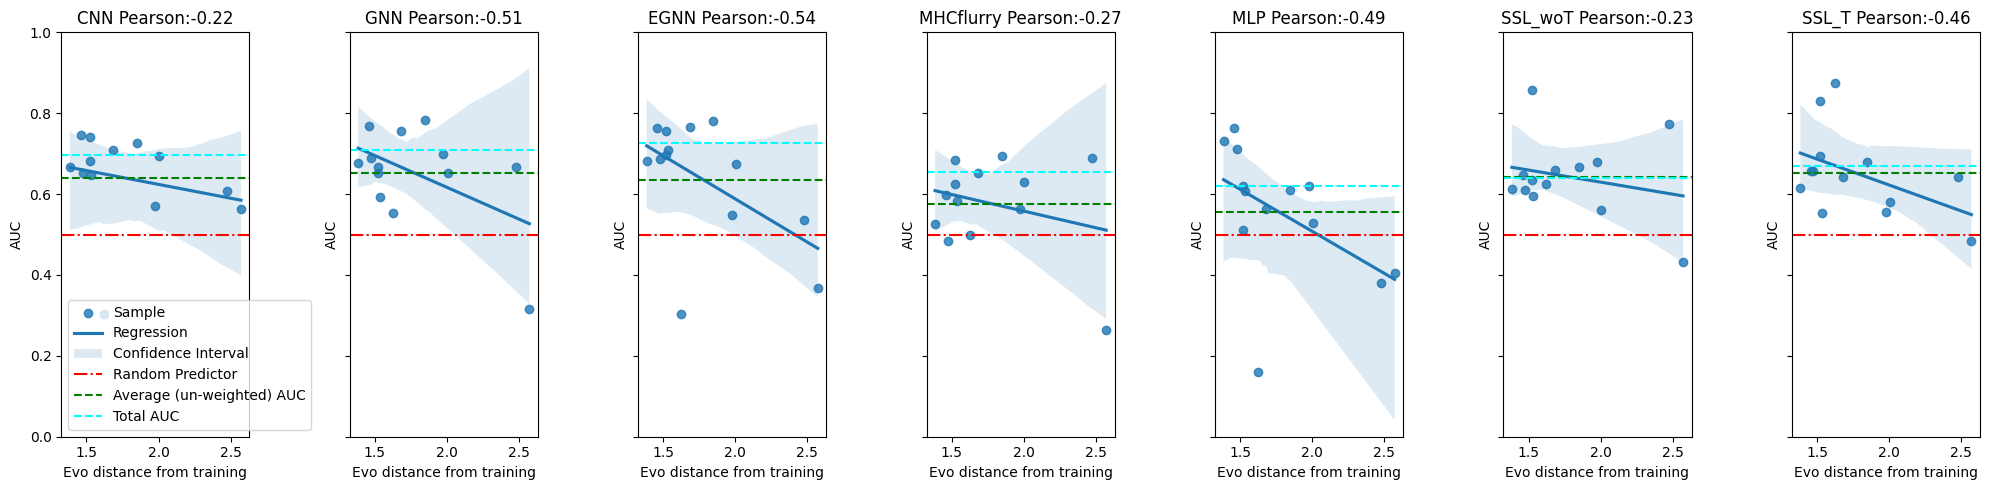

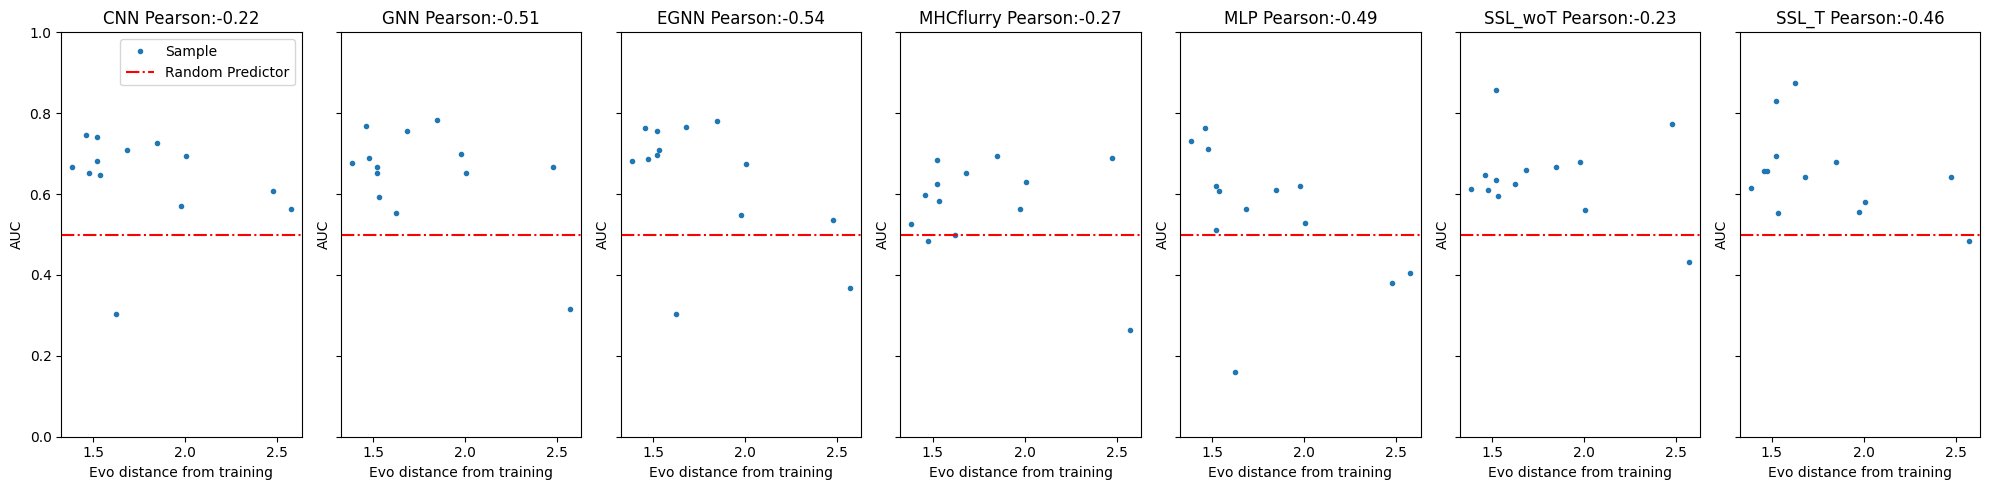

[('CNN', 0.6969536505877688), ('GNN', 0.7087085808696671), ('EGNN', 0.7268719479732882), ('MHCflurry', 0.65456587865395), ('MLP', 0.6192429568079454), ('SSL_woT', 0.6409994258429146), ('SSL_T', 0.6683604900045097)]


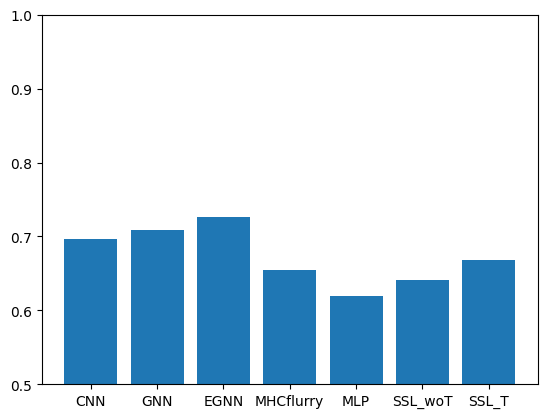

In [14]:
def get_model_output(title, dfot, dfi):
    ## Get output and distance per allele
    allele_outputs = {}
    
    for allele in test_alleles:
        gene = allele.split('*')[0].split('-')[1]
        if allele in matrix['ALL'].keys():
            #identify all the allele's IDs
            IDs = dfi.loc[dfi['allele'] == allele, 'ID'].values
            dfauc = pd.merge(dfi[dfi['ID'].isin(IDs)], dfot[dfot['ID'].isin(IDs)], on='ID')
            if len(dfauc)>0:
                allele_outputs[allele] = {}
                auc = classMetrics.roc_auc(dfauc[label_per_model[title][0]], dfauc[label_per_model[title][1]])
                allele_outputs[allele]['auc'] = auc
                allele_outputs[allele]['distance']= get_avg_distance(allele, matrix['ALL'], test_alleles) #matrix[gene]
        else:
            print(f'Allele {allele} not in Matrix ALL')
        
    #total AUC
    IDs = dfi['ID'].values
    dfauc = pd.merge(dfi[dfi['ID'].isin(IDs)], dfot[dfot['ID'].isin(IDs)], on='ID')
    allele_outputs['total_auc'] = classMetrics.roc_auc(dfauc[label_per_model[title][0]], dfauc[label_per_model[title][1]])
    allele_outputs['total_auprc'] = auprc(dfauc[label_per_model[title][1]], dfauc[label_per_model[title][0]])
    print(f'TITLE {title}, AUC {allele_outputs["total_auc"]}')
    
    return allele_outputs

def get_shuff_auc(title, dfot, dfi):
    IDs = dfi['ID'].values
    dfauc = pd.merge(dfi[dfi['ID'].isin(IDs)], dfot[dfot['ID'].isin(IDs)], on='ID')
    return classMetrics.roc_auc(dfauc[label_per_model[title][0]], dfauc[label_per_model[title][1]])

def get_shuff_auprc(title, dfot, dfi):
    IDs = dfi['ID'].values
    dfauc = pd.merge(dfi[dfi['ID'].isin(IDs)], dfot[dfot['ID'].isin(IDs)], on='ID')
    return auprc(dfauc[label_per_model[title][1]], dfauc[label_per_model[title][0]])


models_outputs = {}
#%% CNN outputs
title = 'CNN'
dfot = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/cnn_outputs/allele_cnn_outputs.csv')
#dfot = dfo[dfo['PHASE'].str.contains('testing', case=False)]
dfot['TARGET'] = dfot['TARGET'].astype(float)
dfot['ID'] = dfot['KEY']

models_outputs[title] = get_model_output(title, dfot, clust_dfi)

# GNN outputs
title = 'GNN'
dfot = pd.read_hdf('/projects/0/einf2380/data/pMHCI/trained_models/deeprank2/experiments/exp_100k_std_transf_bs64_naivegnn1_wloss_cl_allele_0_230607/output/output_exporter.hdf5'
                  , key="testing")
dfot['entry']= [x.split(':')[2] for x in dfot['entry']]
dfot['ID'] = dfot['entry']
dfot['output']= [x[1] for x in dfot['output']]

models_outputs[title] = get_model_output(title, dfot, clust_dfi)

#%% EGNN outputs
def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))
title = 'EGNN'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/egnn_outputs/egnn_supervised_allele.csv')
dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
dfot['OUTPUT_1']=sigmoid(dfot['OUTPUT_0'])
dfot['TARGET'] = dfot['TARGET'].astype(float)
dfot['ID'] = dfot['KEY']

models_outputs[title] = get_model_output(title, dfot, clust_dfi)


#%% MHCflurry outputs
title='MHCflurry'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/mhcflurry_outputs/allele_mhcflurry_outputs.csv',
                header=None, names=['ID', 'BA', 'OUTPUT_1'])

models_outputs[title] = get_model_output(title, dfo, clust_dfi)

#%% MLP 
title='MLP'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/mlp_outputs/allele_mlp_outputs.csv',
                header=None, names=['ID', 'BA', 'OUTPUT_1'])

models_outputs[title] = get_model_output(title, dfo, clust_dfi)

#%% SSL without TCRs outputs

title = 'SSL_woT'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/egnn_outputs/egnn_ssl_no_tcr_allele.csv')
dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
dfot['OUTPUT_1']=sigmoid(dfot['OUTPUT_0'])
dfot['TARGET'] = dfot['TARGET'].astype(float)
dfot['ID'] = dfot['KEY']

models_outputs[title] = get_model_output(title, dfot, clust_dfi)

#%% SSL without TCRs outputs

title = 'SSL_T'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/egnn_outputs/egnn_ssl_allele.csv')
dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
dfot['OUTPUT_1']=sigmoid(dfot['OUTPUT_0'])
dfot['TARGET'] = dfot['TARGET'].astype(float)
dfot['ID'] = dfot['KEY']

models_outputs[title] = get_model_output(title, dfot, clust_dfi)

#%% Plot barplots

#fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig = go.Figure()

correlations = {}

# Iterate over the allele_outputs dictionary and titles list
for i, title in enumerate(models_outputs.keys()):
    allele_outputs = models_outputs[title]

    # Extract sample names and values from the dictionary
    labels = [f"{x} D:{allele_outputs[x]['distance']:.1f} N{(clust_dfi['allele'] == x).sum()}" for x in allele_outputs if 'total' not in x]
    values = [allele_outputs[x]['auc'] for x in allele_outputs if 'total' not in x]

    # Create a Plotly bar plot
    #fig = go.Figure(data=[go.Bar(x=labels, y=values)])
    fig.add_trace(go.Bar(x=labels, y=values, name=title))

    # Customize the layout if needed
fig.update_layout(title='AUC per test allele', xaxis_title='Sample Names and avg distance', yaxis_title='Values')

# Adjust layout and show the plot
# plt.tight_layout()
fig.show()
fig.write_image("/home/dmarz/3D-Vac/reports/figures/AUCperAllele.pdf")

#%% Plot regplot

fig, axes = plt.subplots(1, len(models_outputs), figsize=(20, 5), sharey=True)
correlations = {}

# Iterate over the allele_outputs dictionary and titles list
for i, title in enumerate(models_outputs.keys()):
    allele_outputs = models_outputs[title]
    x = [allele_outputs[x]['distance'] for x in allele_outputs if 'total' not in x]
    y = [allele_outputs[x]['auc'] for x in allele_outputs if 'total' not in x]
    
    correlations[title] = np.corrcoef(x, y)[0][1]
    
    # Create scatter plot with regression line
    sns.regplot(x=x, y=y, ci=99, n_boot=1000, ax=axes[i]) #lowess=True)
    axes[i].axhline(0.5, linestyle='-.', color='red', label='Baseline')
    axes[i].axhline(np.mean(y), linestyle='--', color='green', label='Average AUC')
    axes[i].axhline(np.mean(allele_outputs['total_auc']), linestyle='--', color='cyan', label='Total AUC')
    
    # Customize individual subplot
    axes[i].set_title(f'{title} Pearson:{correlations[title]:.2f}')
    axes[i].set_xlabel('Evo distance from training')
    axes[i].set_ylabel('AUC')
    
    if i == 0:
        axes[i].legend(labels=['Sample', 'Regression', 'Confidence Interval', 'Random Predictor', 'Average (un-weighted) AUC', 'Total AUC'])

# Set common y-label for all subplots
axes[0].set_ylabel('AUC')
axes[0].set_ylim(0,1.0)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


#%% Plot scatterplot

fig, axes = plt.subplots(1, len(models_outputs), figsize=(20, 5), sharey=True)
correlations = {}

# Iterate over the allele_outputs dictionary and titles list
for i, title in enumerate(models_outputs.keys()):
    allele_outputs = models_outputs[title]
    x = [allele_outputs[x]['distance'] for x in allele_outputs if 'total' not in x]
    y = [allele_outputs[x]['auc'] for x in allele_outputs if 'total' not in x]
    
    correlations[title] = np.corrcoef(x, y)[0][1]
    
    # Create scatter plot with regression line
    axes[i].plot(x, y, '.') #lowess=True)
    axes[i].axhline(0.5, linestyle='-.', color='red', label='Baseline')
    #axes[i].axhline(np.mean(y), linestyle='--', color='green', label='Average AUC')
    #axes[i].axhline(np.mean(allele_outputs['total_auc']), linestyle='--', color='cyan', label='Total AUC')
    
    # Customize individual subplot
    axes[i].set_title(f'{title} Pearson:{correlations[title]:.2f}')
    axes[i].set_xlabel('Evo distance from training')
    axes[i].set_ylabel('AUC')
    
    if i == 0:
        axes[i].legend(labels=['Sample', 'Random Predictor'])

# Set common y-label for all subplots
axes[0].set_ylabel('AUC')
axes[0].set_ylim(0,1.0)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

plt.clf()
print([(x, models_outputs[x]['total_auc']) for x in models_outputs])
plt.bar([x for x in models_outputs], [models_outputs[x]['total_auc'] for x in models_outputs])
plt.ylim(0.5,1.0)
plt.show()

# fig = go.Figure()
# for x in models_outputs:
#     fig.add_trace(go.Bar(x=models_outputs[x], y=models_outputs[x]['total_auc'], name=title))


### Plot shuffled set performances

In [15]:

#%% Shuffled performances

#dfi = pd.read_csv('/projects/0/einf2380/data/external/processed/I/experiments/BA_pMHCI_human_quantitative_only_eq_pseudoseq_clustered_test.csv')
shuff_dfi = pd.read_csv('/projects/0/einf2380/data/external/processed/I/experiments/BA_pMHCI_human_quantitative_only_eq_shuffled_test.csv')
shuff_dfi['label'] = np.where(shuff_dfi['measurement_value'] < 500, 1.0, 0.0)

#models_outputs = {}
AUCs = {}
AUPRCs = {}

title = 'CNN'
dfot = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/cnn_outputs/shuffled_cnn_outputs.csv')
#dfot = dfo[dfo['PHASE'].str.contains('testing', case=False)]
dfot['TARGET'] = dfot['TARGET'].astype(float)
dfot['ID'] = dfot['KEY']

AUCs[title] = get_shuff_auc(title, dfot, shuff_dfi)
AUPRCs[title] = get_shuff_auprc(title, dfot, shuff_dfi)

# GNN outputs
title = 'GNN'
dfot = pd.read_hdf(
    '/projects/0/einf2380/data/pMHCI/trained_models/deeprank2/experiments/exp_100k_std_transf_bs64_naivegnn1_wloss_0_230607/output/output_exporter.hdf5'
                  , key="testing")
dfot['entry']= [x.split(':')[2] for x in dfot['entry']]
dfot['ID'] = dfot['entry']
dfot['output']= [x[1] for x in dfot['output']]

AUCs[title] = get_shuff_auc(title, dfot, shuff_dfi)
AUPRCs[title] = get_shuff_auprc(title, dfot, shuff_dfi)

#%% EGNN outputs
def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))
title = 'EGNN'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/egnn_outputs/egnn_supervised_shuffle.csv')
dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
dfot['OUTPUT_1']=sigmoid(dfot['OUTPUT_0'])
dfot['TARGET'] = dfot['TARGET'].astype(float)
dfot['ID'] = dfot['KEY']

AUCs[title] = get_shuff_auc(title, dfot, shuff_dfi)
AUPRCs[title] = get_shuff_auprc(title, dfot, shuff_dfi)

#%% SSL without TCRs outputs

title = 'SSL_woT'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/egnn_outputs/egnn_ssl_no_tcr_shuffle.csv')
dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
dfot['OUTPUT_1']=sigmoid(dfot['OUTPUT_0'])
dfot['TARGET'] = dfot['TARGET'].astype(float)
dfot['ID'] = dfot['KEY']

AUCs[title] = get_shuff_auc(title, dfot, shuff_dfi)
AUPRCs[title] = get_shuff_auprc(title, dfot, shuff_dfi)

#%% SSL with TCRs outputs

title = 'SSL_T'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/egnn_outputs/egnn_ssl_shuffle.csv')
dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
dfot['OUTPUT_1']=sigmoid(dfot['OUTPUT_0'])
dfot['TARGET'] = dfot['TARGET'].astype(float)
dfot['ID'] = dfot['KEY']

AUCs[title] = get_shuff_auc(title, dfot, shuff_dfi)
AUPRCs[title] = get_shuff_auprc(title, dfot, shuff_dfi)


#%% MHCflurry outputs
title='MHCflurry'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/mhcflurry_outputs/shuffled_mhcflurry_outputs.csv',
                header=None, names=['ID', 'BA', 'OUTPUT_1'])

AUCs[title] = get_shuff_auc(title, dfo, shuff_dfi)
AUPRCs[title] = get_shuff_auprc(title, dfo, shuff_dfi)

# #%% MHCflurry confirmed outputs
# title='MHCflurry_confirm'
# dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/mhcflurry_outputs/mhcflurry_confirm_shuffled.csv',
#                 )
# dfo['ID'] = dfo['KEY']
# AUCs[title] = get_shuff_auc(title, dfo, shuff_dfi)

#%% MLP 
title='MLP'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/mlp_outputs/shuffled_mlp_outputs.csv',
                header=None, names=['ID', 'BA', 'OUTPUT_1'])

AUCs[title] = get_shuff_auc(title, dfo, shuff_dfi)
AUPRCs[title] = get_shuff_auprc(title, dfo, shuff_dfi)

#plt.bar(AUCs.keys(), AUCs.values())
fig = go.Figure()
fig.add_trace(go.Bar(x=list(AUCs.keys()), y=list(AUCs.values())))
fig.show()
AUCs

{'CNN': 0.8571122982726461,
 'GNN': 0.8558345956142034,
 'EGNN': 0.8710504014272971,
 'SSL_woT': 0.6523308350407313,
 'SSL_T': 0.6556257029998448,
 'MHCflurry': 0.8146540477715316,
 'MLP': 0.9047854999594517}

### Reorder dictionaries for figure plotting

In [16]:
#%% Reorder and rename

allele_aucs = {x: models_outputs[x]['total_auc'] for x in models_outputs}
allele_auprcs = {x: models_outputs[x]['total_auprc'] for x in models_outputs}
#allele_aucs['3D-GPT'] = allele_aucs['SSL_T']
#del allele_aucs['SSL_T']
order = ['CNN', 'GNN', 'EGNN', 'MHCflurry', 'MLP', 'SSL_T', 'SSL_woT']
allele_aucs = {x:allele_aucs[x] for x in order}
allele_auprcs = {x:allele_auprcs[x] for x in order}

#AUCs['3D-SSL'] = AUCs['SSL_T']
#del AUCs['SSL_T']
#AUCs.pop('SSL_woT')
#AUCs.pop('SSL_T')
AUCs = {x:AUCs[x] for x in order}
AUPRCs = {x:AUPRCs[x] for x in order}


### Barplot plotting for the manuscript

In [25]:
def plot_barplot(x, y, color, xlabel, ylabel, title, 
                save=False, ylim=(0.5, 1.0), 
                baseline=False):
    fig, ax = plt.subplots(1,1)

    # Save the chart so we can loop through the bars below.
    bars = plt.bar(
        x=x,
        height=y,
        tick_label=x,
        color=color
    )

    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
    ax.set_ylim(ylim)
    if baseline:
        plt.axhline(baseline, linestyle='-.', color='grey')

    #ax.legend(x)
    
    # Add text annotations to the top of the bars.
    #bar_color = bars[0].get_facecolor()
    for bar in bars:
      ax.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 0.02,
          f'{bar.get_height():.2}',
          horizontalalignment='center',
          color=bar.get_facecolor(),
          weight='bold'
      )

    # Add labels and a title.
    ax.set_xlabel(xlabel, labelpad=15, color='#333333')
    ax.set_ylabel(ylabel, labelpad=15, color='#333333')
    ax.set_title(title, pad=15, color='#333333',
                weight='bold')

    
    
    fig.tight_layout()
    
    if save:
        plt.savefig(f'{save}.png', dpi=400)
        plt.savefig(f'{save}.pdf')


### PLOT AUCs

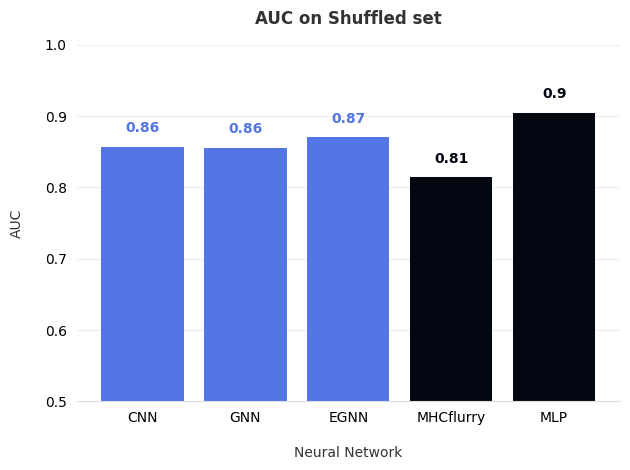

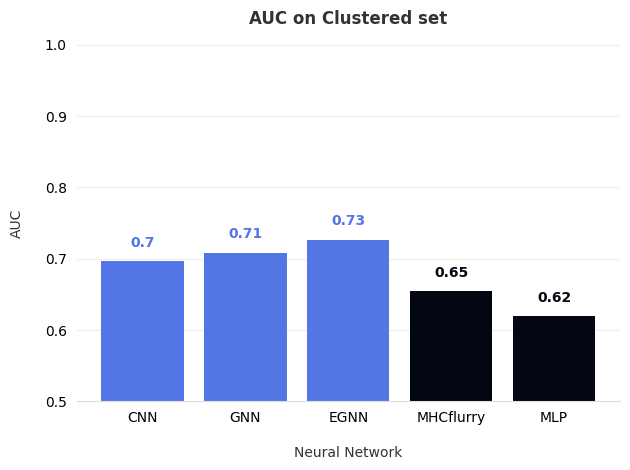

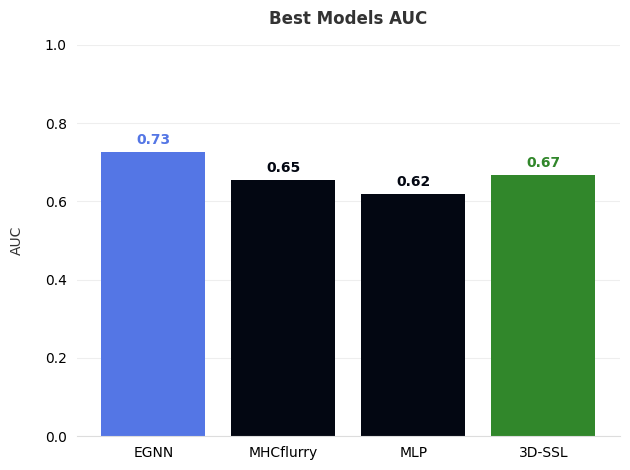

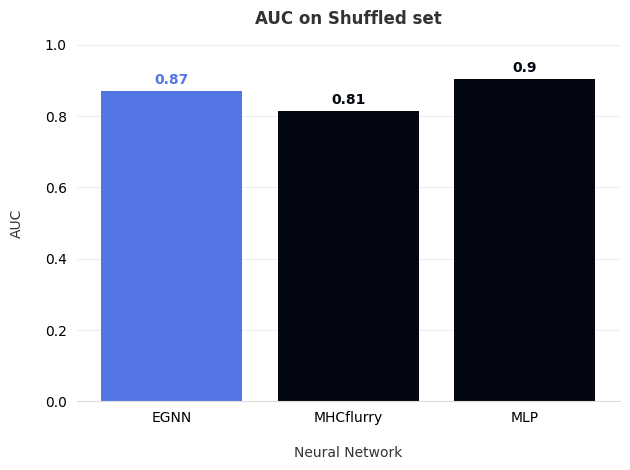

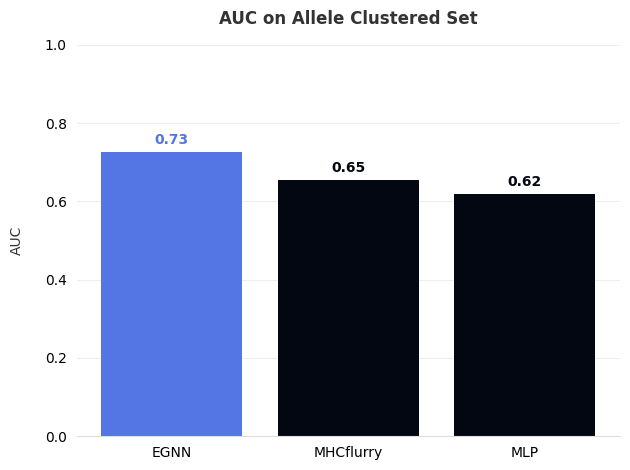

In [27]:
# Plot StrB and SeqB shuffled
models = ['CNN', 'GNN', 'EGNN', 'MHCflurry', 'MLP']
x = models
y = [AUCs[key] for key in models]
color = ['#5476E5','#5476E5', '#5476E5', '#030712', '#030712']
xlabel='Neural Network'
ylabel='AUC'
title='AUC on Shuffled set'
plot_barplot(x, y, color, xlabel, ylabel, title, save = f'/home/dmarz/3D-Vac/reports/figures/AUC_shuffled')

# Plot StrB and SeqB clustered
models = ['CNN', 'GNN', 'EGNN', 'MHCflurry', 'MLP']
x = models
y = [allele_aucs[key] for key in models]
color = ['#5476E5','#5476E5', '#5476E5', '#030712', '#030712']
xlabel='Neural Network'
ylabel='AUC'
title='AUC on Clustered set'

plot_barplot(x, y, color, xlabel, ylabel, title, save = f'/home/dmarz/3D-Vac/reports/figures/AUC_clust_allele')

# # Plot SSL
# # Could add best StrB and best SeqB method as comparison
# models = ['3D-SSL no TCR s', '3D-SSL TCR s', '3D-SSL no TCR c', '3D-SSL TCR c']
# x = models
# y = [AUCs[key] for key in ['SSL_woT', 'SSL_T']] + [allele_aucs[key] for key in ['SSL_woT', 'SSL_T']]
# color = ['#c07715','#31872b', '#c07715', '#31872b'] #['#c07715','#c59063', '#31872b', '#6e8e77']
# #xlabel='Neural Network'
# xlabel=''
# ylabel='AUC'
# title='AUC 3D-SSL'

# plot_barplot(x, y, color, xlabel, ylabel, title, save = f'/home/dmarz/3D-Vac/reports/figures/AUC_SSL')

# Plot SSL summary
# Could add best StrB and best SeqB method as comparison
models = ['EGNN', 'MHCflurry', 'MLP', '3D-SSL']
x = models
y = [allele_aucs[key] for key in ['EGNN', 'MHCflurry', 'MLP', 'SSL_T']]
color = ['#5476E5', '#030712', '#030712', '#31872b']
xlabel=''
ylabel='AUC'
title='Best Models AUC'

plot_barplot(x, y, color, xlabel, ylabel, title, ylim=(0.0, 1.0), save = f'/home/dmarz/3D-Vac/reports/figures/SSL_summary_AUC')


models = ['EGNN', 'MHCflurry', 'MLP']
x = models
y = [AUCs[key] for key in models]
color = ['#5476E5', '#030712', '#030712']
xlabel='Neural Network'
ylabel='AUC'
title='AUC on Shuffled set'
plot_barplot(x, y, color, xlabel, ylabel, title, ylim=(0.0, 1.0))#, save = f'/home/dmarz/3D-Vac/reports/figures/AUC_shuffled')


models = ['EGNN', 'MHCflurry', 'MLP']#, '3D-SSL']
x = models
y = [allele_aucs[key] for key in ['EGNN', 'MHCflurry', 'MLP']]#, 'SSL_T']]
color = ['#5476E5', '#030712', '#030712']#, '#3B3B3B']
xlabel=''
ylabel='AUC'
title='AUC on Allele Clustered Set'

plot_barplot(x, y, color, xlabel, ylabel, title, ylim=(0.0, 1.0))#, save = f'/home/dmarz/3D-Vac/reports/figures/SSL_summary_AUC')


### PLOT AUPRCs

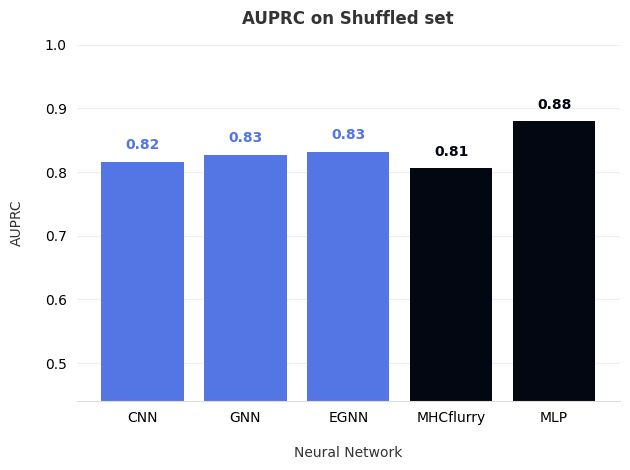

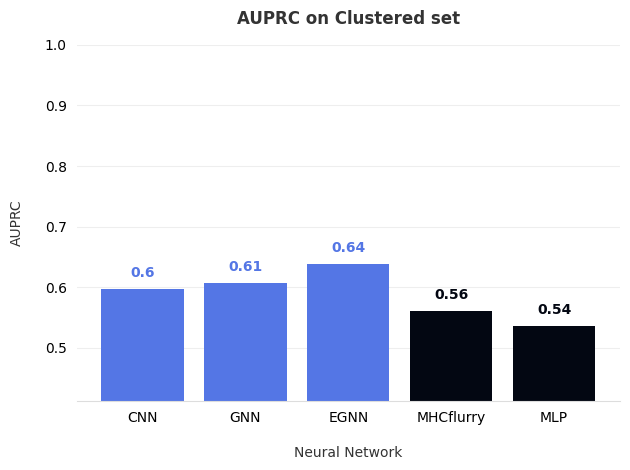

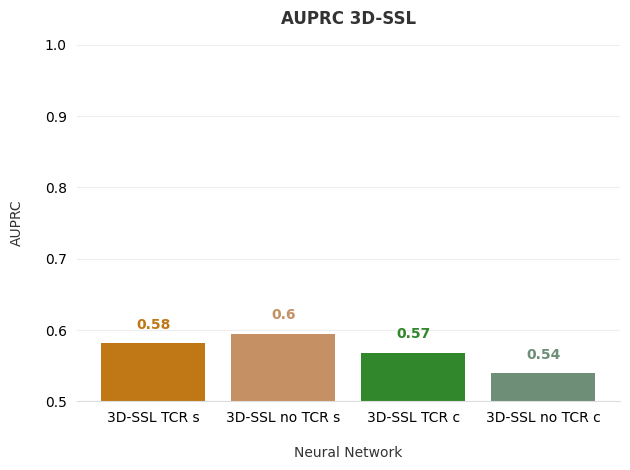

In [ ]:
# Get AUPRC baseline values
clust_baseline = len(clust_dfi[clust_dfi['label']==1.0])/len(clust_dfi)
shuff_baseline = len(shuff_dfi[shuff_dfi['label']==1.0])/len(shuff_dfi)


# Plot StrB and SeqB shuffled
models = ['CNN', 'GNN', 'EGNN', 'MHCflurry', 'MLP']
x = models
y = [AUPRCs[key] for key in models]
color = ['#5476E5','#5476E5', '#5476E5', '#030712', '#030712']
xlabel='Neural Network'
ylabel='AUPRC'
title='AUPRC on Shuffled set'
plot_barplot(x, y, color, xlabel, ylabel, title, 
            ylim=(shuff_baseline, 1.0),
            save = f'/home/dmarz/3D-Vac/reports/figures/AUPRC_shuffled')

# Plot StrB and SeqB clustered
models = ['CNN', 'GNN', 'EGNN', 'MHCflurry', 'MLP']
x = models
y = [allele_auprcs[key] for key in models]
color = ['#5476E5','#5476E5', '#5476E5', '#030712', '#030712']
xlabel='Neural Network'
ylabel='AUPRC'
title='AUPRC on Clustered set'

plot_barplot(x, y, color, xlabel, ylabel, title, 
                ylim=(clust_baseline, 1.0),
                save = f'/home/dmarz/3D-Vac/reports/figures/AUPRC_clust_allele')

# Plot SSL
# Could add best StrB and best SeqB method as comparison
models = ['3D-SSL TCR s', '3D-SSL no TCR s', '3D-SSL TCR c', '3D-SSL no TCR c']
x = models
y = [AUPRCs[key] for key in ['SSL_T', 'SSL_woT']] + [allele_auprcs[key] for key in ['SSL_T', 'SSL_woT']]
color = ['#c07715','#c59063', '#31872b', '#6e8e77']
xlabel='Neural Network'
ylabel='AUPRC'
title='AUPRC 3D-SSL'

plot_barplot(x, y, color, xlabel, ylabel, title, save = f'/home/dmarz/3D-Vac/reports/figures/AUPRC_SSL')




In [ ]:
shuff_baseline

0.4397801099450275

In [ ]:
clust_baseline

0.4116061976710615